# Training du RNN pour le captioning

# Intro

blablabla

# préparation de l'environnement

In [1]:
#imports
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

import tensorboard
import datetime

import cv2

In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Chargement des données

In [3]:
# Chemin du fichier d'annotations
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
#On va prendre des images pré débruité par le modele du livrable 2 pour l'entrainement.
image_folder = '/denoised_train2014/'
PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = '<start> ' + val['caption'] + ' <end>' #A COMPLETER
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption) #A COMPLETER
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []


print(len(train_image_paths))

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list) #A COMPLETER
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list)) #A COMPLETER
    #print(len(caption_list))

print(train_captions)

print(len(img_name_vector))


2000
['<start> A very clean and well decorated empty bathroom <end>', '<start> A blue and white bathroom with butterfly themed wall tiles. <end>', '<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>', '<start> An angled view of a beautifully decorated bathroom. <end>', '<start> A clock that blends in with the wall hangs in a bathroom.  <end>', '<start> A panoramic view of a kitchen and all of its appliances. <end>', '<start> A panoramic photo of a kitchen and dining room <end>', '<start> A wide angle view of the kitchen work area <end>', '<start> multiple photos of a brown and white kitchen.  <end>', '<start> A kitchen that has a checkered patterned floor and white cabinets. <end>', '<start> A graffiti-ed stop sign across the street from a red car  <end>', '<start> A vandalized stop sign and a red beetle on the road <end>', '<start> A red stop sign with a Bush bumper sticker under the word stop. <end>', '<start> A stop sign that has been vandali

## Débruiteur
On entrera des images débruités dans notre CNN. Pour qu'il s'habitue a des images débruités

In [4]:
# #L2------
# model_denoising_path = "../Livrable_2/best_model/17_4_2024_17h12.keras"
# model_denoising = tf.keras.models.load_model(model_denoising_path)

# #L2
# def prepare_denoising(path):
#     img = cv2.imread(path)
#     img_correct_color = img
#     img_resized = cv2.resize(img_correct_color, (400,400))
#     img_normalized = img_resized.astype('float32') / 255.0
#     img_batch = np.expand_dims(img_normalized, axis=0)
#     return img_batch

In [5]:
# dossier = "denoised_train2014"
# for path in range(img_name_vector):
#     name = img_name_vector[path].split('/')[-1]
#     img = prepare_denoising(path)
#     img = model_denoising.predict(img)

#     cv2.imwrite(f'./{dossier}/{name}', img.squeeze()*255)




## Préparation d'inceptionV3

Au début, le modèle InceptionV3 est téléchargé sans la couche supérieure (qui est la couche de classification) et avec des poids pré-entraînés sur ImageNet. Une nouvelle couche d'entrée est créée avec la forme (299,299,3), qui est la forme d'entrée attendue par InceptionV3. La dernière couche cachée du modèle, qui contient la représentation compacte de l'image, est récupérée. Un nouveau modèle, `image_features_extract_model`, est ensuite créé avec la nouvelle entrée et la dernière couche cachée du modèle InceptionV3.

Ensuite, une fonction `load_image` est définie. Cette fonction prend un chemin d'image en entrée et renvoie un tuple contenant l'image traitée et son chemin. Les étapes de traitement de l'image comprennent le chargement du fichier image, le décodage de l'image en RGB, le redimensionnement de l'image à (299, 299), et la normalisation des pixels de l'image entre -1 et 1 en utilisant la fonction `preprocess_input` de InceptionV3.

Nous procédons ensuite au prétraitement des images. Il obtient d'abord les noms uniques des images de `img_name_vector` et les trie. Un jeu de données TensorFlow est créé à partir de ces noms d'images. La fonction `load_image` est ensuite appliquée à ce jeu de données en parallèle, et le jeu de données est divisé en lots de 16.

Nous iterrons ensuite sur chaque lot du jeu de données. Pour chaque lot, le `image_features_extract_model` est utilisé pour calculer les caractéristiques des images. Les caractéristiques sont ensuite remodelées de (16,8,8,2048) à (16,64,2048). Pour chaque image du lot, le chemin de l'image et les caractéristiques sont sauvegardés dans un fichier en utilisant `numpy.save`. Le chemin du fichier est le même que le chemin de l'image, et les caractéristiques sont sauvegardées dans le format binaire numpy. Ce processus est répété pour tous les lots dans le jeu de données.

In [6]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pre-traitement d'InceptionV3
print(image_dataset)
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


## Préparation du tokenizer

Le tokenizer va nous servir de dictionnaire. La bibliothèque Keras nous donne les mots les plus communs, nous avons choisi les 5000 premiers (voir la variable `top_k`). On crée ensuite le dictionnaire avec la méthode `fit_on_texts`, il sera basé sur les annotations du dataset Coco train 2014 et attribuera un token (un id entre 1 et 5000) à chaque mot.
Ainsi, notre RNN nous renverra un vecteur de tokens que nous traduirons en mots à la fin.

In [7]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] =  0
tokenizer.index_word[0] =  '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector =   tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)


## Split test/train

Nous créons les jeux d'entraînement et de test, pour les photos ainsi que les annotations.
Nous affichons leur longueur pour s'assurer de la bonne exécution de la fonction.

In [8]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)



len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8004, 8004, 2001, 2001)

# Entrainement

## Définition des paramètres

In [9]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 32 # taille du batch
BUFFER_SIZE = 8000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Encodeur CNN
sortie d'inceptionV3 blablabla

In [10]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## Décodeur RNN
blabla intro RNN
### Mécanisme d'attention
blabla badhanau

In [11]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

       # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
                    #(BATCH_SIZE,64,hidden_size) + (BATCH_SIZE,1,hidden_size)


        # attention_weights shape == (batch_size, 64, 1)
        # You get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)


        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        
        return context_vector, attention_weights

### Décodeur
blabla décodeur, gru etc

In [12]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
#A COMPLETER

        self.attention = BahdanauAttention(self.units)
#A COMPLETER

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
#A COMPLETER
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
#A COMPLETER

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
#A COMPLETER
        
        y = tf.reshape(output, (-1, x.shape[2]))

        # Couche dense
        y = x = self.fc1(y)
#A COMPLETER

        
        
        # Couche dense
        y = self.fc2(x)
#A COMPLETER
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Combinaison encodeur + décodeur

In [13]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
#A COMPLETER
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Prepare training loop
### Optimizer and Loss
blabla

In [14]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam(0.001)
#A COMPLETER
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Callbacks
blabla callbacks

In [15]:

#CALLBACKS


def get_val_loss(dataset, encoder, decoder):
    total_loss = 0
    for (batch,(img_tensor, target)) in enumerate(dataset):
        loss = 0
        # Initialisation de l'état caché pour chaque batch
        hidden = decoder.reset_state(batch_size=target.shape[0])
        #print(tokenizer.word_index)

        # Initialiser l'entrée du décodeur
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

        t_loss = (loss / int(target.shape[1]))

    
        total_loss += t_loss

    return total_loss
    


class Callbacker():
    def __init__(self, tensorboard = True, early_stopping = True, es_patience = 0, save_model = True):

        time = datetime.datetime.now()
        self.training_name = f"{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"
        #self.best_loss = np.Inf
        self.best_val_loss = np.Inf
        self.wait = 0
        self.stopped_epoch = 0


        self.btensorboard = tensorboard
        self.bearly_stopping = early_stopping
        self.es_patience = es_patience
        self.save_model = save_model

        self.stop_training = False

        if self.btensorboard == True:
            self.writer= tf.summary.create_file_writer(f"tensorboard/{self.training_name}")


    def epoch_callback(self, encoder_model, decoder_model, num_epoch:int, current_loss:float, current_val_loss:float):
        """
        at each epoch, this function will be launched, we will record our weights and save our model if we have the best result since the beeginning of the training.
        this function need as parameters:
        - encoder model: the encoder model (usually RNN).
        - decoder: the decoder model (usually RNN)
        - num epoch : the current epoch number
        - current loss : the current train loss
        - current_val_loss : the current loss for validation
        """
        print(f"The average loss for epoch {num_epoch} is loss :{current_loss}, val loss : {current_val_loss}")

        if self.btensorboard == True:
            with self.writer.as_default():
                tf.summary.scalar('loss', current_loss, step=num_epoch)
                tf.summary.scalar('val_loss', current_val_loss, step=num_epoch)

        if np.less(current_val_loss, self.best_val_loss):
            #self.best_loss = current_loss
            self.best_val_loss = current_val_loss
            self.wait = 0
            self.encoder_best_weights = encoder_model.get_weights()
            self.decoder_best_weights = decoder_model.get_weights()
            # Record the best weights if current results is better (less).
            if self.save_model == True:
                encoder_model.save(f'./models/{self.training_name}/encoder.tf')
                decoder_model.save(f'./models/{self.training_name}/decoder.tf')
        else:
            if self.bearly_stopping == True:
                self.wait += 1
                if self.wait >= self.es_patience:
                    self.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    encoder_model.set_weights(self.encoder_best_weights)
                    decoder_model.set_weights(self.decoder_best_weights)
        


### Training step function
blabla backpropagation

In [16]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #print(tokenizer.word_index)

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Training
blabla train

Epoch 1 Batch 0 Loss 2.9019
Epoch 1 Batch 100 Loss 1.7013
Epoch 1 Batch 200 Loss 1.4208
The average loss for epoch 0 is loss :1.62021005153656, val loss : 1.3490633964538574
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 1 Loss 1.620210
Time taken for 1 epoch 174.15002179145813 sec

Epoch 2 Batch 0 Loss 1.2433
Epoch 2 Batch 100 Loss 1.2151
Epoch 2 Batch 200 Loss 1.2811
The average loss for epoch 1 is loss :1.300060510635376, val loss : 1.1758900880813599
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 2 Loss 1.300061
Time taken for 1 epoch 135.76465582847595 sec

Epoch 3 Batch 0 Loss 1.1567
Epoch 3 Batch 100 Loss 1.1922
Epoch 3 Batch 200 Loss 1.0614
The average loss for epoch 2 is loss :1.164872646331787, val loss : 1.0534507036209106
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 3 Loss 1.164873
Time taken for 1 epoch 129.08605432510376 sec

Epoch 4 Batch 0 Loss 0.9683
Epoch 4 Batch 100 Loss 1.1420
Epoch 4 Batch 200 Loss 1.0293
The average loss for epoch 3 is loss :1.0657333135604858, val loss : 0.9559950232505798
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 4 Loss 1.065733
Time taken for 1 epoch 129.73010969161987 sec

Epoch 5 Batch 0 Loss 1.0390
Epoch 5 Batch 100 Loss 0.9046
Epoch 5 Batch 200 Loss 0.9192
The average loss for epoch 4 is loss :0.9864731431007385, val loss : 0.8736454248428345
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 5 Loss 0.986473
Time taken for 1 epoch 129.73555541038513 sec

Epoch 6 Batch 0 Loss 0.8591
Epoch 6 Batch 100 Loss 0.8884
Epoch 6 Batch 200 Loss 0.8643
The average loss for epoch 5 is loss :0.9139974117279053, val loss : 0.7982656359672546
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 6 Loss 0.913997
Time taken for 1 epoch 133.85419583320618 sec

Epoch 7 Batch 0 Loss 0.7831
Epoch 7 Batch 100 Loss 0.8224
Epoch 7 Batch 200 Loss 0.7251
The average loss for epoch 6 is loss :0.8464154005050659, val loss : 0.7465582489967346
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 7 Loss 0.846415
Time taken for 1 epoch 132.5537531375885 sec

Epoch 8 Batch 0 Loss 0.7638
Epoch 8 Batch 100 Loss 0.7533
Epoch 8 Batch 200 Loss 0.7683
The average loss for epoch 7 is loss :0.7868040204048157, val loss : 0.6876528859138489
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 8 Loss 0.786804
Time taken for 1 epoch 131.92531085014343 sec

Epoch 9 Batch 0 Loss 0.7548
Epoch 9 Batch 100 Loss 0.7553
Epoch 9 Batch 200 Loss 0.7525
The average loss for epoch 8 is loss :0.7314950823783875, val loss : 0.6310684084892273
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 9 Loss 0.731495
Time taken for 1 epoch 133.68691897392273 sec

Epoch 10 Batch 0 Loss 0.7262
Epoch 10 Batch 100 Loss 0.6377
Epoch 10 Batch 200 Loss 0.7258
The average loss for epoch 9 is loss :0.6818535923957825, val loss : 0.58516925573349
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 10 Loss 0.681854
Time taken for 1 epoch 133.8631489276886 sec

Epoch 11 Batch 0 Loss 0.6390
Epoch 11 Batch 100 Loss 0.6017
Epoch 11 Batch 200 Loss 0.6221
The average loss for epoch 10 is loss :0.6390568614006042, val loss : 0.5414778590202332
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 11 Loss 0.639057
Time taken for 1 epoch 134.92159986495972 sec

Epoch 12 Batch 0 Loss 0.5389
Epoch 12 Batch 100 Loss 0.5626
Epoch 12 Batch 200 Loss 0.5809
The average loss for epoch 11 is loss :0.5961672067642212, val loss : 0.49637743830680847
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 12 Loss 0.596167
Time taken for 1 epoch 131.5539038181305 sec

Epoch 13 Batch 0 Loss 0.4670
Epoch 13 Batch 100 Loss 0.5736
Epoch 13 Batch 200 Loss 0.5834
The average loss for epoch 12 is loss :0.554612398147583, val loss : 0.4531552195549011
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 13 Loss 0.554612
Time taken for 1 epoch 131.56400227546692 sec

Epoch 14 Batch 0 Loss 0.4553
Epoch 14 Batch 100 Loss 0.4760
Epoch 14 Batch 200 Loss 0.5401
The average loss for epoch 13 is loss :0.5173757076263428, val loss : 0.43149736523628235
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 14 Loss 0.517376
Time taken for 1 epoch 131.0647840499878 sec

Epoch 15 Batch 0 Loss 0.4001
Epoch 15 Batch 100 Loss 0.4585
Epoch 15 Batch 200 Loss 0.6045
The average loss for epoch 14 is loss :0.4817495048046112, val loss : 0.39942580461502075
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 15 Loss 0.481750
Time taken for 1 epoch 133.80771112442017 sec

Epoch 16 Batch 0 Loss 0.4260
Epoch 16 Batch 100 Loss 0.4201
Epoch 16 Batch 200 Loss 0.5502
The average loss for epoch 15 is loss :0.4478289783000946, val loss : 0.36567163467407227
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 16 Loss 0.447829
Time taken for 1 epoch 129.64232349395752 sec

Epoch 17 Batch 0 Loss 0.4747
Epoch 17 Batch 100 Loss 0.4007
Epoch 17 Batch 200 Loss 0.4438
The average loss for epoch 16 is loss :0.42073220014572144, val loss : 0.3377225399017334
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 17 Loss 0.420732
Time taken for 1 epoch 126.04263734817505 sec

Epoch 18 Batch 0 Loss 0.3691
Epoch 18 Batch 100 Loss 0.3839
Epoch 18 Batch 200 Loss 0.4473
The average loss for epoch 17 is loss :0.39178651571273804, val loss : 0.3112975060939789
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 18 Loss 0.391787
Time taken for 1 epoch 120.16709923744202 sec

Epoch 19 Batch 0 Loss 0.2745
Epoch 19 Batch 100 Loss 0.3771
Epoch 19 Batch 200 Loss 0.3905
The average loss for epoch 18 is loss :0.3696826696395874, val loss : 0.2964300811290741
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 19 Loss 0.369683
Time taken for 1 epoch 119.59282851219177 sec

Epoch 20 Batch 0 Loss 0.3262
Epoch 20 Batch 100 Loss 0.3862
Epoch 20 Batch 200 Loss 0.3939
The average loss for epoch 19 is loss :0.3474860191345215, val loss : 0.2792894244194031
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 20 Loss 0.347486
Time taken for 1 epoch 118.32523846626282 sec

Epoch 21 Batch 0 Loss 0.3189
Epoch 21 Batch 100 Loss 0.3207
Epoch 21 Batch 200 Loss 0.3711
The average loss for epoch 20 is loss :0.32754597067832947, val loss : 0.2548556625843048
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 21 Loss 0.327546
Time taken for 1 epoch 118.27027940750122 sec

Epoch 22 Batch 0 Loss 0.2324
Epoch 22 Batch 100 Loss 0.2978
Epoch 22 Batch 200 Loss 0.3271
The average loss for epoch 21 is loss :0.3102485239505768, val loss : 0.24257387220859528
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 22 Loss 0.310249
Time taken for 1 epoch 119.69194269180298 sec

Epoch 23 Batch 0 Loss 0.2290
Epoch 23 Batch 100 Loss 0.2775
Epoch 23 Batch 200 Loss 0.2781
The average loss for epoch 22 is loss :0.295152485370636, val loss : 0.22846055030822754
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 23 Loss 0.295152
Time taken for 1 epoch 119.60317730903625 sec

Epoch 24 Batch 0 Loss 0.2452
Epoch 24 Batch 100 Loss 0.2579
Epoch 24 Batch 200 Loss 0.3281
The average loss for epoch 23 is loss :0.28552505373954773, val loss : 0.22802652418613434
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 24 Loss 0.285525
Time taken for 1 epoch 118.26145219802856 sec

Epoch 25 Batch 0 Loss 0.2344
Epoch 25 Batch 100 Loss 0.2714
Epoch 25 Batch 200 Loss 0.3318
The average loss for epoch 24 is loss :0.27038413286209106, val loss : 0.21523161232471466
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 25 Loss 0.270384
Time taken for 1 epoch 118.58765244483948 sec

Epoch 26 Batch 0 Loss 0.2394
Epoch 26 Batch 100 Loss 0.2338
Epoch 26 Batch 200 Loss 0.2852
The average loss for epoch 25 is loss :0.2597709894180298, val loss : 0.21243613958358765
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 26 Loss 0.259771
Time taken for 1 epoch 120.57104825973511 sec

Epoch 27 Batch 0 Loss 0.2302
Epoch 27 Batch 100 Loss 0.2332
Epoch 27 Batch 200 Loss 0.2840
The average loss for epoch 26 is loss :0.250794380903244, val loss : 0.19864805042743683
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 27 Loss 0.250794
Time taken for 1 epoch 150.63693165779114 sec

Epoch 28 Batch 0 Loss 0.1831
Epoch 28 Batch 100 Loss 0.2620
Epoch 28 Batch 200 Loss 0.2475
The average loss for epoch 27 is loss :0.2392662614583969, val loss : 0.19143107533454895
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 28 Loss 0.239266
Time taken for 1 epoch 149.00134253501892 sec

Epoch 29 Batch 0 Loss 0.1891
Epoch 29 Batch 100 Loss 0.2246
Epoch 29 Batch 200 Loss 0.2687
The average loss for epoch 28 is loss :0.2330838143825531, val loss : 0.18441535532474518
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 29 Loss 0.233084
Time taken for 1 epoch 147.64659309387207 sec

Epoch 30 Batch 0 Loss 0.1807
Epoch 30 Batch 100 Loss 0.2051
Epoch 30 Batch 200 Loss 0.2516
The average loss for epoch 29 is loss :0.22710320353507996, val loss : 0.17915289103984833
INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/encoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


INFO:tensorflow:Assets written to: ./models/25_4_2024_22h20/decoder.tf\assets


Epoch 30 Loss 0.227103
Time taken for 1 epoch 156.79484629631042 sec



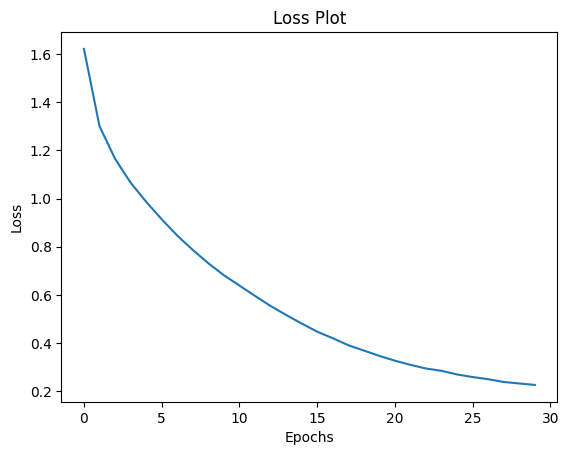

In [17]:
EPOCHS = 30

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
val_dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
val_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



callbacker = Callbacker(es_patience= 3)

#create the directory
os.makedirs(f'./models/{callbacker.training_name}')
#save of the tokenizer
with open(f'./models/{callbacker.training_name}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    #VALIDATION-------------------------------------------------------
    val_loss = get_val_loss(val_dataset,encoder,decoder)
    #------------------------------------------------------------------        
    
    #CALLBACK --------------------------------------------------------
    callbacker.epoch_callback(encoder, decoder, epoch, total_loss/num_steps, val_loss/num_steps)
    #-----------------------------------------------------------------
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# display the trained model's results
Fonctions:

In [18]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Reshape predictions to be a 2D matrix of shape [batch_size, vocab_size]
        predictions = tf.reshape(predictions, [1, -1])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Affichage

d:\CESI\A5\datascience\Projet\DataScience\Livrable_3/denoised_train2014/COCO_train2014_000000085452.jpg
Real Caption: <start> a microwave oven with its door open sits on the bathroom floor next to the commode <end>
Prediction Caption: black and white photo of a microwave <end>


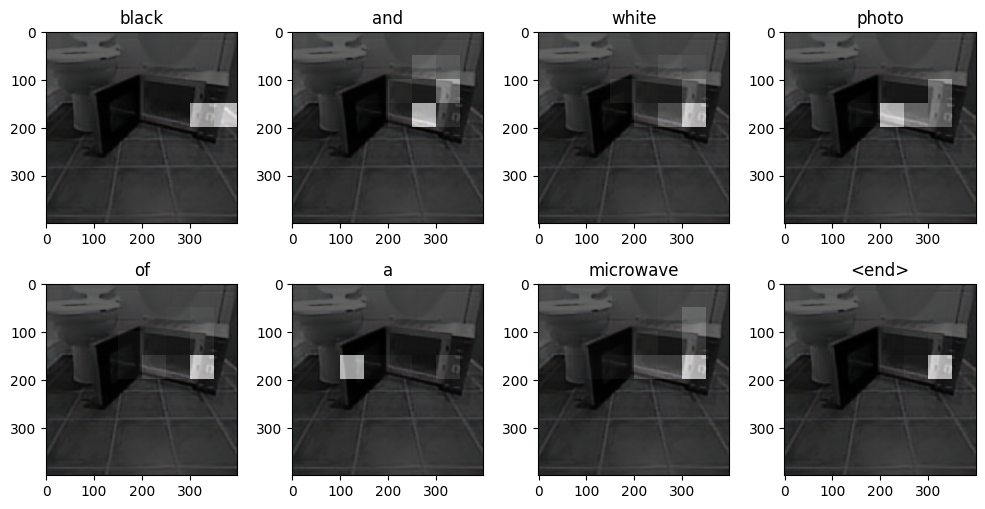

In [21]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# Sélection du meilleur modèle
Grâce à nos callbacks, Nous pouvons avoir l'évolution de nos entrainements de manière visuelle a l'aide de tensorboard. 

Ainsi, nous avons réalisé plusieurs entrainements, avec différents paramêtres. Nous avons modifiés:
- Le batch size, pour changer la fréquence d'apprentissage dans l'epoch
- La learning rate pour modifier la vitesse d'apprentissage a chaque apprentissage
- Le buffer size
- Le nombre d'image lors de l'entrainement pour avoir plus d'exemple (multiplie le temps d'entrainement)

Voici un graphique de nos loss par epoch sur nos différents entrainements
![Courbes Loss](attachment/tensorboard.png)

La loss que nous avons pris ne suffisait pas a maximiser les résultats, mais elle donnait un bonne indicateur sur la pertinences des termes choisis.

Voici un exemple d'excellent caption obtenu par notre modèle sur le jeu de test(c'est une photo avec un chat dans un évier).

![Courbes Loss](attachment/captioning_example.png)


# Problèmes rencontrés et améliorations
Après sélection d'un modèle performant, en essayant de faire la pipeline globale du projet avec les 3 modèles, le débruitage du modèle de denoising c'éait du flou (car on perdait un peu d'infos avec les convolutions). Ainsi le modèle voyait uniquement du flou, il a fallu refaire l'entrainement avec un dataset de photos dénoisés.

Nous pouvons améliorer la qualité des captions générés en prenant en compte une autre loss, la loss Blue (keras_nlp.metrics.Blue).

# Conclusion

Nous avons donc notre modèle capable de générer un caption à partir d' images.

Nous n'avons plus qu'a emboiter nos modèles pour faire notre pipeline finale pour ce projet.